# Notebook 6 — Mutual Information Plots

Visualise mutual information (MI) across cities × years.

**MI definition** (from `utils/dkl.py`):
$$\text{MI}(\text{CBSA}) = \sum_i p_{ni} \cdot \text{DKL}_{\text{block}}(i)$$

where $p_{ni}$ is the block group's share of the CBSA total and
$\text{DKL}_{\text{block}}(i)$ is the block-level Kullback–Leibler divergence.

**Inputs**: `data/acs5_block_{year}_data/mi_*.parquet`  
**Outputs**: Charts displayed inline; optionally saved to `figures/`


In [1]:
# ── Standard imports ────────────────────────────────────────────────────────
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

warnings.filterwarnings('ignore')

# ── Resolve pipeline root so config.py is importable ────────────────────────
NOTEBOOK_DIR = Path().resolve()
PIPELINE_DIR = NOTEBOOK_DIR.parent   # pipeline/
if str(PIPELINE_DIR) not in sys.path:
    sys.path.insert(0, str(PIPELINE_DIR))

from config import DATA_DIR, CITIES

print(f'DATA_DIR : {DATA_DIR}')
print(f'CITIES   : {CITIES}')


DATA_DIR : /Users/bettencourt/Desktop/dkl-metric/pipeline/data
CITIES   : ['Chicago-Naperville-Elgin, IL-IN-WI', 'Houston-The Woodlands-Sugar Land, TX', 'Atlanta-Sandy Springs-Alpharetta, GA', 'New York-Newark-Jersey City, NY-NJ-PA']


## 1. Load MI Parquet Files

Discover every `mi_*.parquet` file under `DATA_DIR`, infer the variable group
and year from the filename, and stack them into a single DataFrame.


In [2]:
def _year_from_tag(tag: str) -> int:
    """Convert a 2-digit year tag to a 4-digit year (e.g. '20' → 2020)."""
    n = int(tag)
    return 2000 + n if n < 50 else 1900 + n


def load_all_mi(data_dir: Path) -> pd.DataFrame:
    """
    Walk data_dir for mi_*.parquet files, attach var_group + year metadata,
    and concatenate into one DataFrame.

    Expected filename pattern:
        mi_{var_group}_{yr_short}_blkgrp_all_states.parquet
    e.g.:
        mi_income_20_blkgrp_all_states.parquet
    """
    frames = []
    for path in sorted(data_dir.rglob('mi_*.parquet')):
        stem = path.stem  # e.g. mi_income_20_blkgrp_all_states
        parts = stem.split('_')
        # parts[0] = 'mi', parts[1] = var_group, parts[2] = yr_short
        if len(parts) < 3:
            continue
        var_group = parts[1]
        yr_tag    = parts[2]
        try:
            year = _year_from_tag(yr_tag)
        except ValueError:
            continue
        df = pd.read_parquet(path)
        df['var_group'] = var_group
        df['year']      = year
        frames.append(df)
        print(f'  Loaded {path.name}  ({len(df):,} rows)')

    if not frames:
        raise FileNotFoundError(
            f'No mi_*.parquet files found under {data_dir}.\n'
            'Run pipeline/4_mutual_info.py first.'
        )

    mi = pd.concat(frames, ignore_index=True)
    print(f'\nTotal rows : {len(mi):,}')
    print(f'Var groups : {sorted(mi["var_group"].unique())}')
    print(f'Years      : {sorted(mi["year"].unique())}')
    return mi


mi_df = load_all_mi(DATA_DIR)
mi_df.head()


  Loaded mi_educ_15_blkgrp_all_states.parquet  (998 rows)
  Loaded mi_empl_15_blkgrp_all_states.parquet  (998 rows)
  Loaded mi_income_15_blkgrp_all_states.parquet  (998 rows)
  Loaded mi_race_15_blkgrp_all_states.parquet  (998 rows)
  Loaded mi_educ_20_blkgrp_all_states.parquet  (998 rows)
  Loaded mi_empl_20_blkgrp_all_states.parquet  (998 rows)
  Loaded mi_income_20_blkgrp_all_states.parquet  (998 rows)
  Loaded mi_race_20_blkgrp_all_states.parquet  (998 rows)

Total rows : 7,984
Var groups : ['educ', 'empl', 'income', 'race']
Years      : [np.int64(2015), np.int64(2020)]


,cbsa_title,state_codes,group_label,avg_dkl_cbsa_pop,var_group,year
0,"Aberdeen, SD",SD,Education attainment,0.259353,educ,2015
1,"Aberdeen, WA",WA,Education attainment,0.327024,educ,2015
2,"Abilene, TX",TX,Education attainment,0.469087,educ,2015
3,"Ada, OK",OK,Education attainment,0.206304,educ,2015
4,"Adrian, MI",MI,Education attainment,0.265790,educ,2015


In [3]:
# Preview schema and basic stats
print(mi_df.dtypes)
print()
mi_df[['avg_dkl_cbsa_pop', 'year']].describe()


cbsa_title           object
state_codes          object
group_label          object
avg_dkl_cbsa_pop    float64
var_group            object
year                  int64
dtype: object



,avg_dkl_cbsa_pop,year
count,7984.000000,7984.000000
mean,0.298457,2017.500000
std,0.208078,2.500157
min,0.006208,2015.000000
25%,0.092716,2015.000000
50%,0.301572,2017.500000
75%,0.445511,2020.000000
max,1.391777,2020.000000


## 2. Bar Charts — avg_dkl_cbsa_pop by CBSA for Each Variable Group

For each variable group, show the top 30 CBSAs by population-weighted MI,
faceted by year.  The bars reveal which metros are most / least segregated
on that dimension.


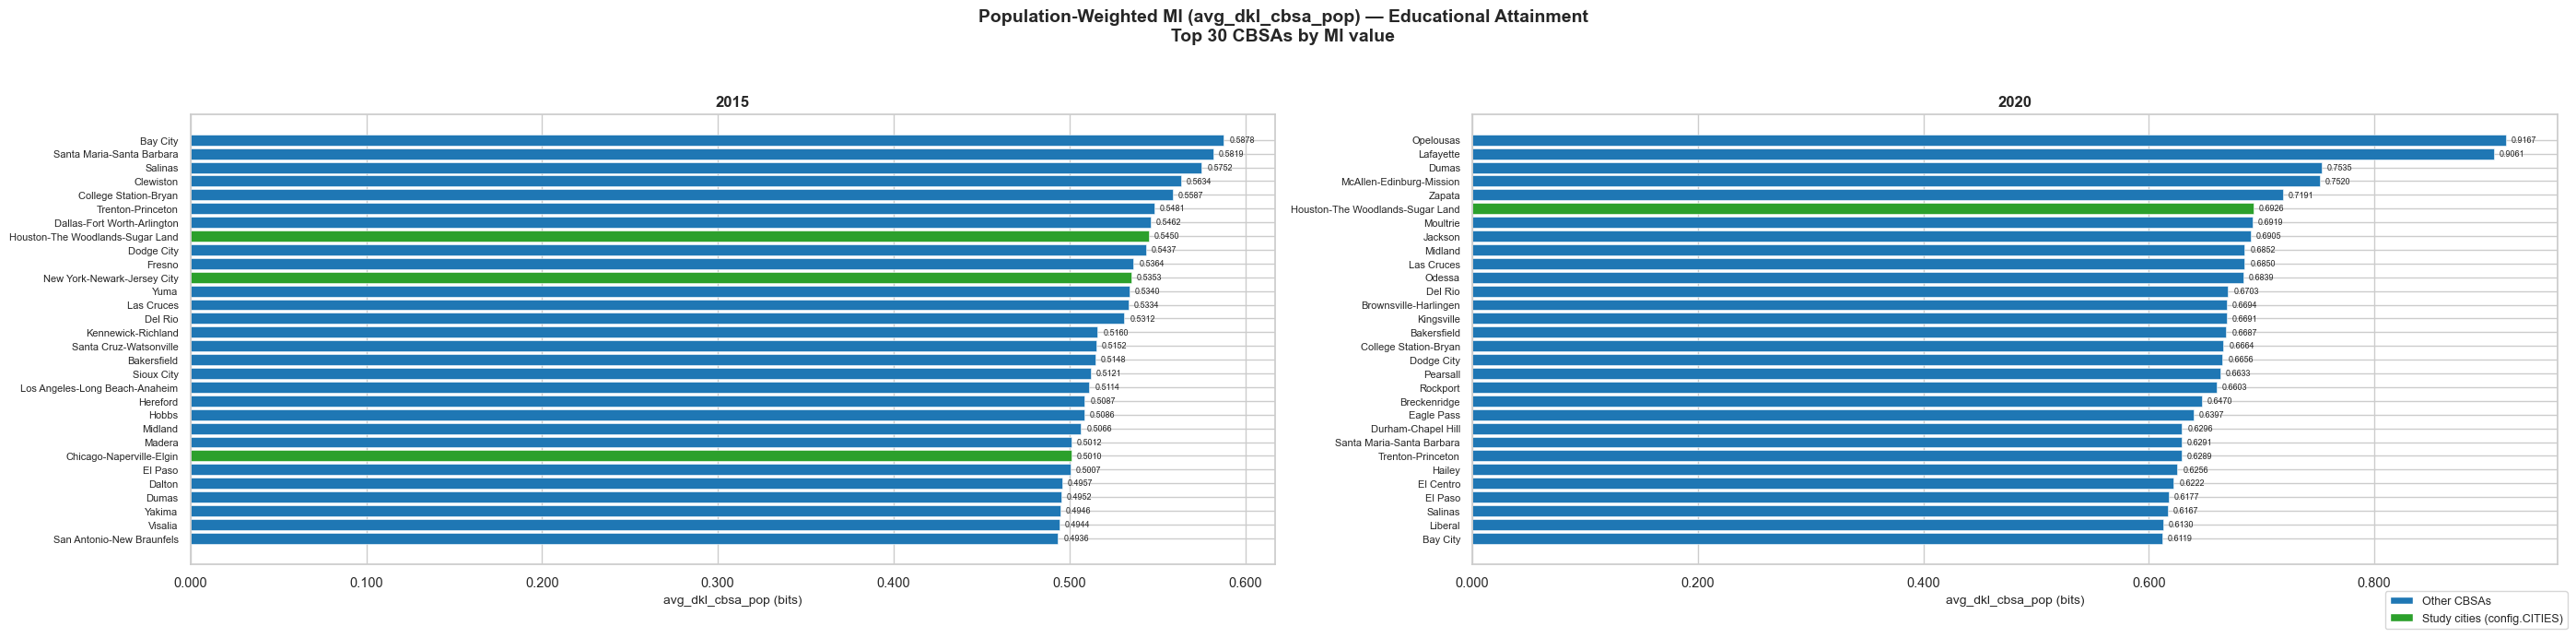

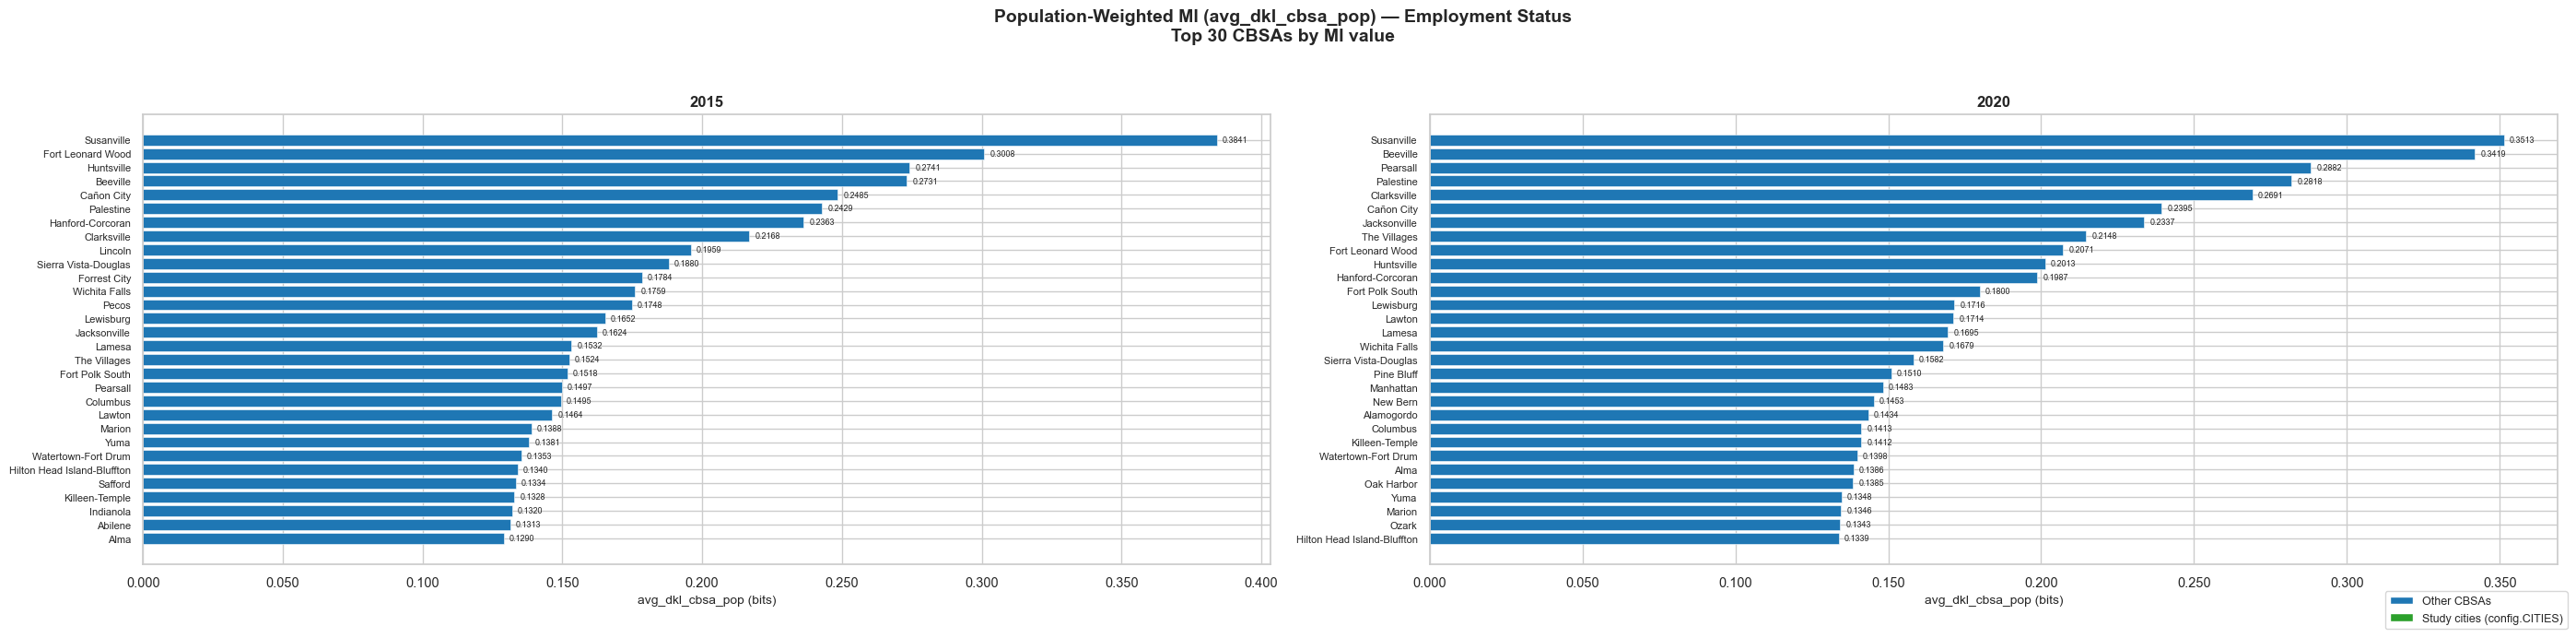

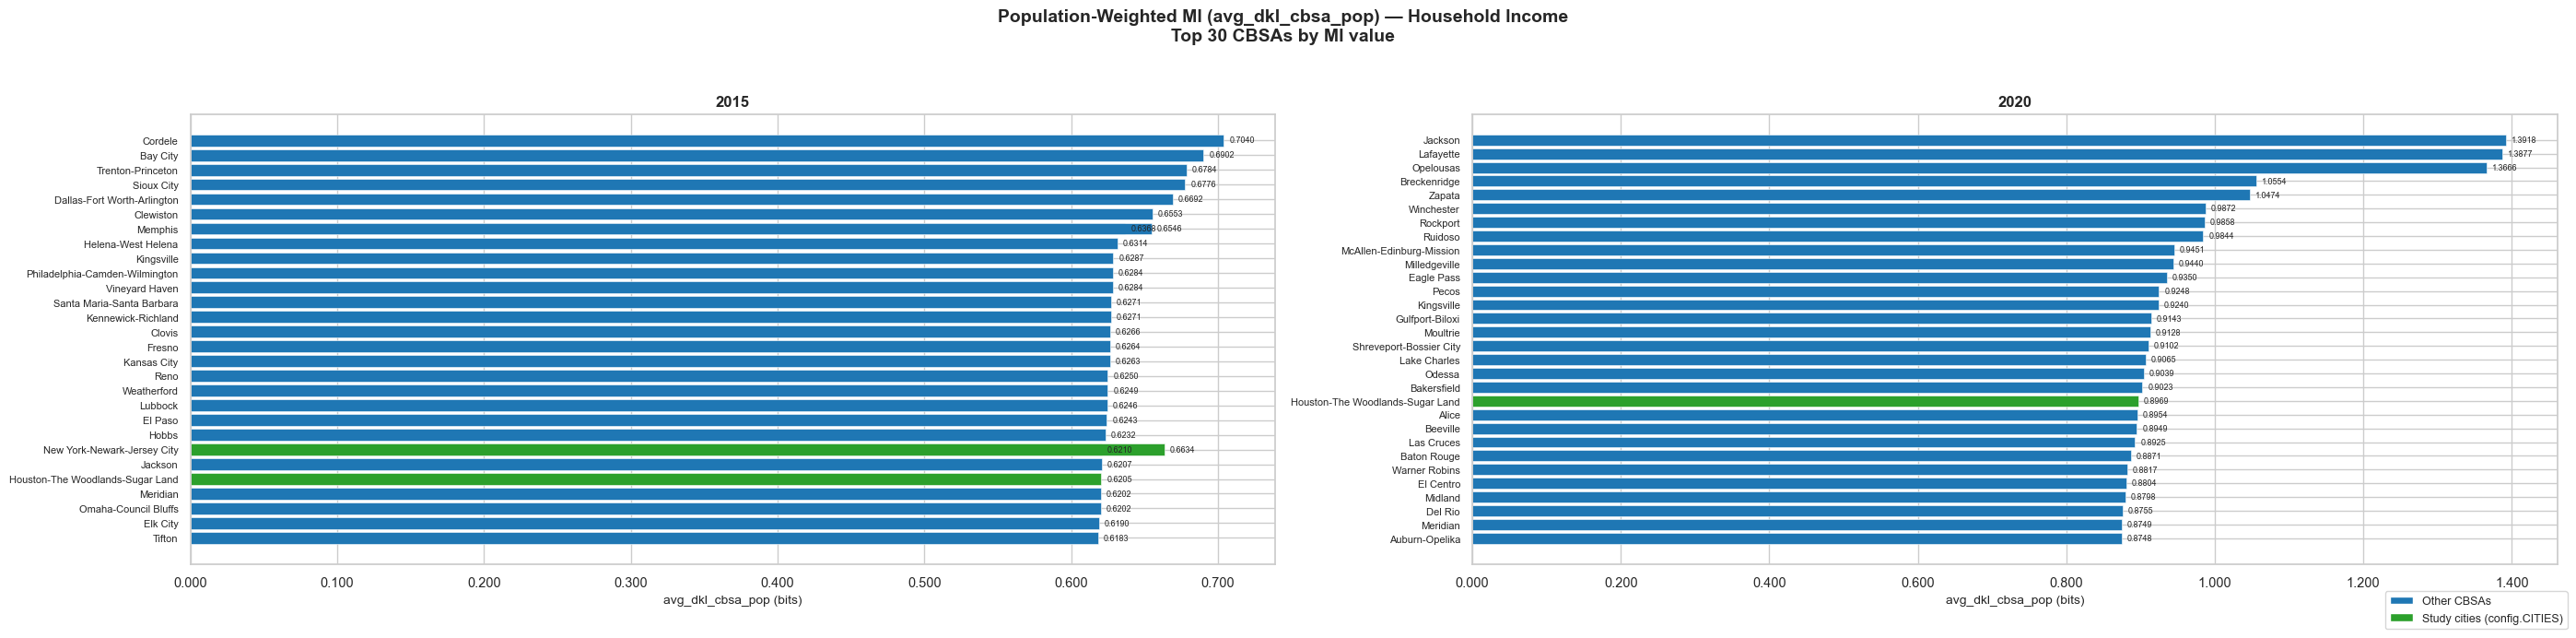

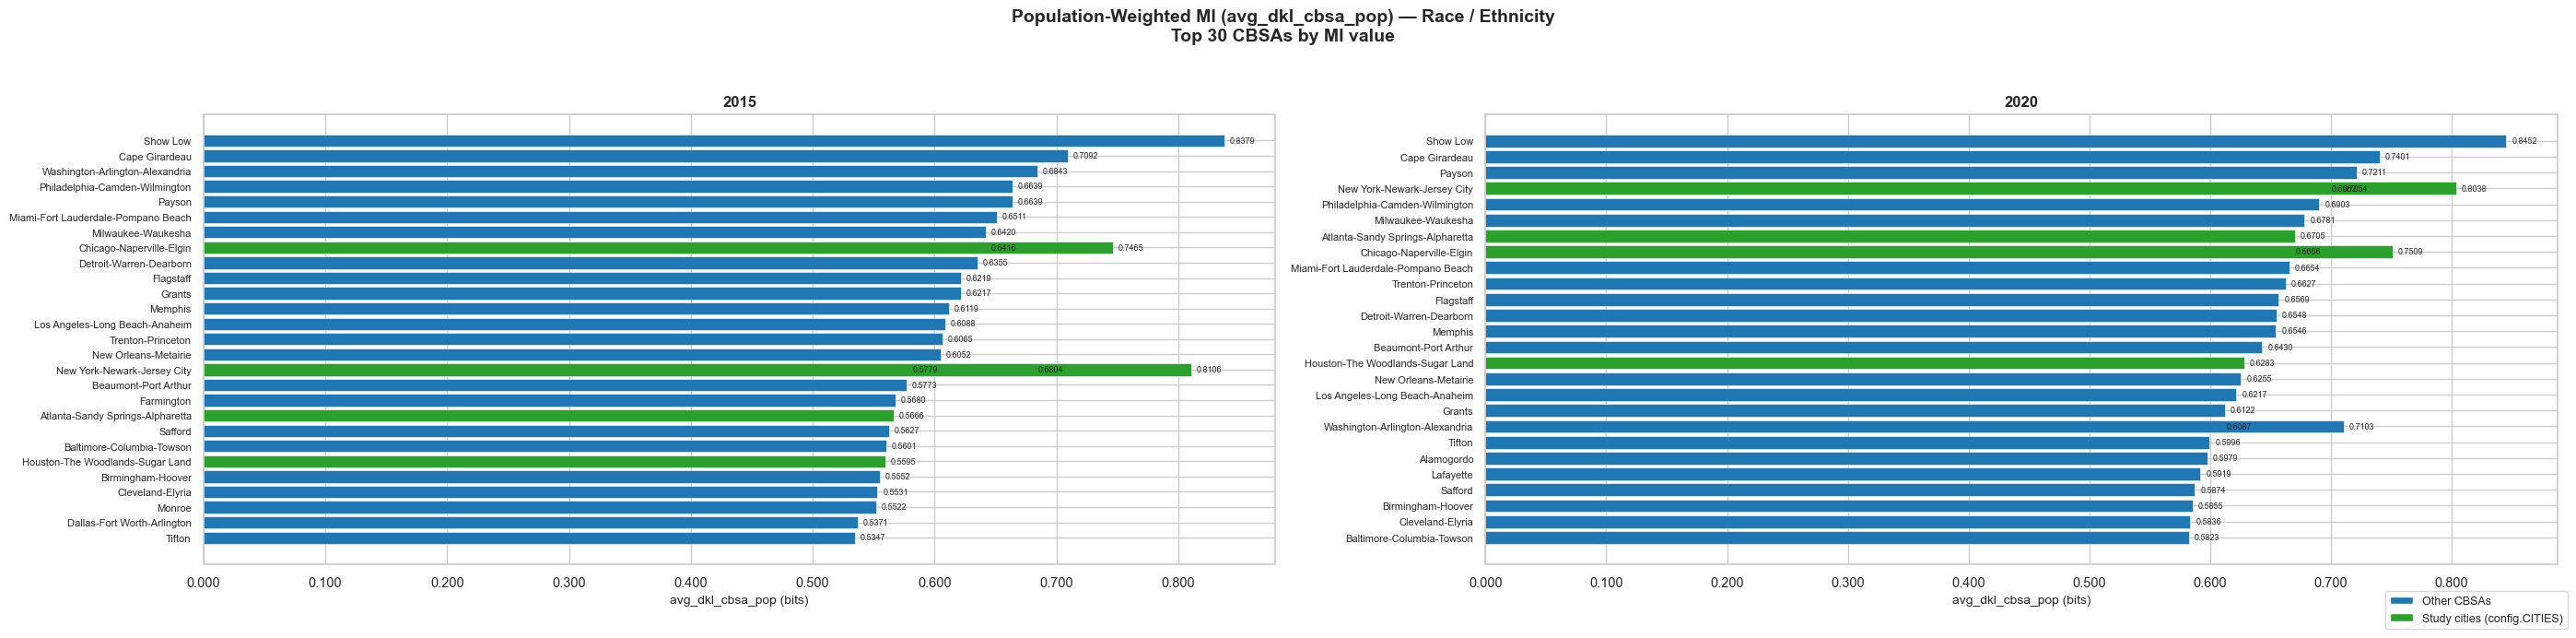

In [4]:
VAR_GROUP_LABELS = {
    'income': 'Household Income',
    'race'  : 'Race / Ethnicity',
    'educ'  : 'Educational Attainment',
    'empl'  : 'Employment Status',
}

PALETTE = sns.color_palette('tab10')
sns.set_theme(style='whitegrid', font_scale=0.95)


def plot_cbsa_bar(mi: pd.DataFrame, var_group: str,
                  top_n: int = 30, figsize_per_year=(14, 7)) -> None:
    """
    For one variable group, plot horizontal bar charts of avg_dkl_cbsa_pop
    for the top-N CBSAs.  One subplot per year.
    """
    sub = mi[mi['var_group'] == var_group].copy()
    if sub.empty:
        print(f'No data for var_group={var_group!r}')
        return

    years = sorted(sub['year'].unique())
    n_years = len(years)
    fig, axes = plt.subplots(
        1, n_years,
        figsize=(figsize_per_year[0] * n_years, figsize_per_year[1]),
        sharey=False
    )
    if n_years == 1:
        axes = [axes]

    vg_label = VAR_GROUP_LABELS.get(var_group, var_group.title())
    fig.suptitle(
        f'Population-Weighted MI (avg_dkl_cbsa_pop) — {vg_label}\n'
        f'Top {top_n} CBSAs by MI value',
        fontsize=14, fontweight='bold'
    )

    for ax, yr in zip(axes, years):
        yr_data = (
            sub[sub['year'] == yr]
            .dropna(subset=['avg_dkl_cbsa_pop', 'cbsa_title'])
            .nlargest(top_n, 'avg_dkl_cbsa_pop')
            .sort_values('avg_dkl_cbsa_pop', ascending=True)
        )
        if yr_data.empty:
            ax.set_title(f'{yr} — no data')
            continue

        # Shorten very long CBSA names for readability
        yr_data['cbsa_short'] = yr_data['cbsa_title'].str.split(',').str[0]

        colors = [PALETTE[2] if c in CITIES else PALETTE[0]
                  for c in yr_data['cbsa_title']]

        bars = ax.barh(
            yr_data['cbsa_short'],
            yr_data['avg_dkl_cbsa_pop'],
            color=colors, edgecolor='white', linewidth=0.4
        )
        ax.set_xlabel('avg_dkl_cbsa_pop (bits)', fontsize=10)
        ax.set_title(f'{yr}', fontsize=12, fontweight='bold')
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
        ax.tick_params(axis='y', labelsize=8)

        # Annotate values at end of each bar
        for bar in bars:
            w = bar.get_width()
            ax.text(
                w + ax.get_xlim()[1] * 0.005,
                bar.get_y() + bar.get_height() / 2,
                f'{w:.4f}', va='center', ha='left', fontsize=6.5
            )

    # Legend: highlight study cities
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=PALETTE[0], label='Other CBSAs'),
        Patch(facecolor=PALETTE[2], label='Study cities (config.CITIES)'),
    ]
    fig.legend(handles=legend_elements, loc='lower right',
               bbox_to_anchor=(1.0, 0.01), fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# ── Plot for every available variable group ──────────────────────────────────
for vg in sorted(mi_df['var_group'].unique()):
    plot_cbsa_bar(mi_df, vg)


## 3. Violin / Boxplot — MI Distribution by Year

Show the full distribution of CBSA-level `avg_dkl_cbsa_pop` across all metros,
split by variable group and year.  Violins show density; the embedded box shows
median and IQR.


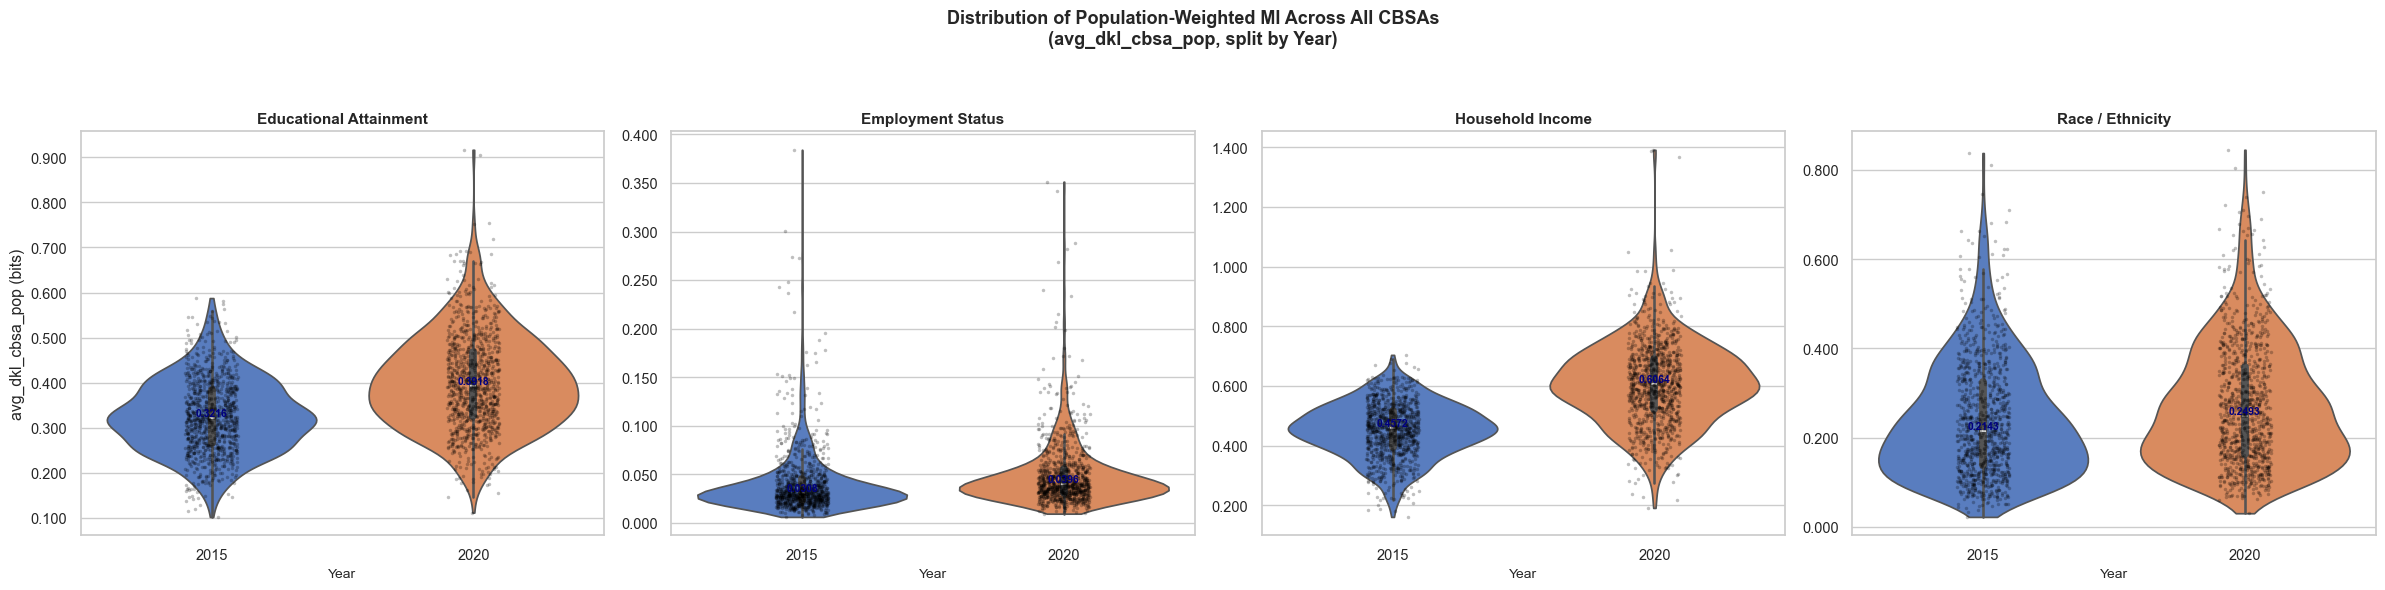

In [5]:
def plot_violin_by_year(mi: pd.DataFrame) -> None:
    """Violin + box of avg_dkl_cbsa_pop by (var_group × year)."""
    df = mi.dropna(subset=['avg_dkl_cbsa_pop']).copy()
    df['var_label'] = df['var_group'].map(VAR_GROUP_LABELS).fillna(df['var_group'].str.title())
    df['year_str']  = df['year'].astype(str)

    var_labels = sorted(df['var_label'].unique())
    n_vars = len(var_labels)

    fig, axes = plt.subplots(1, n_vars, figsize=(6 * n_vars, 6), sharey=False)
    if n_vars == 1:
        axes = [axes]

    fig.suptitle(
        'Distribution of Population-Weighted MI Across All CBSAs\n'
        '(avg_dkl_cbsa_pop, split by Year)',
        fontsize=13, fontweight='bold'
    )

    for ax, vl in zip(axes, var_labels):
        sub = df[df['var_label'] == vl]
        years_present = sorted(sub['year_str'].unique())

        sns.violinplot(
            data=sub, x='year_str', y='avg_dkl_cbsa_pop',
            order=years_present,
            palette='muted', inner='box', cut=0, ax=ax
        )
        # Overlay individual CBSA points (jittered strip)
        sns.stripplot(
            data=sub, x='year_str', y='avg_dkl_cbsa_pop',
            order=years_present,
            color='black', alpha=0.25, size=2.5, jitter=True, ax=ax
        )
        ax.set_title(vl, fontsize=11, fontweight='bold')
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel('avg_dkl_cbsa_pop (bits)' if vl == var_labels[0] else '')
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))

        # Annotate median per year
        for i, yr in enumerate(years_present):
            median = sub[sub['year_str'] == yr]['avg_dkl_cbsa_pop'].median()
            ax.text(i, median, f'{median:.4f}',
                    ha='center', va='bottom', fontsize=7.5,
                    color='navy', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


plot_violin_by_year(mi_df)


## 4. Year-over-Year Change in MI

For each variable group, compute $\Delta\text{MI} = \text{MI}_{t} - \text{MI}_{t-1}$
at the CBSA level and plot the distribution of changes.  Positive values mean
increasing segregation; negative values indicate convergence.


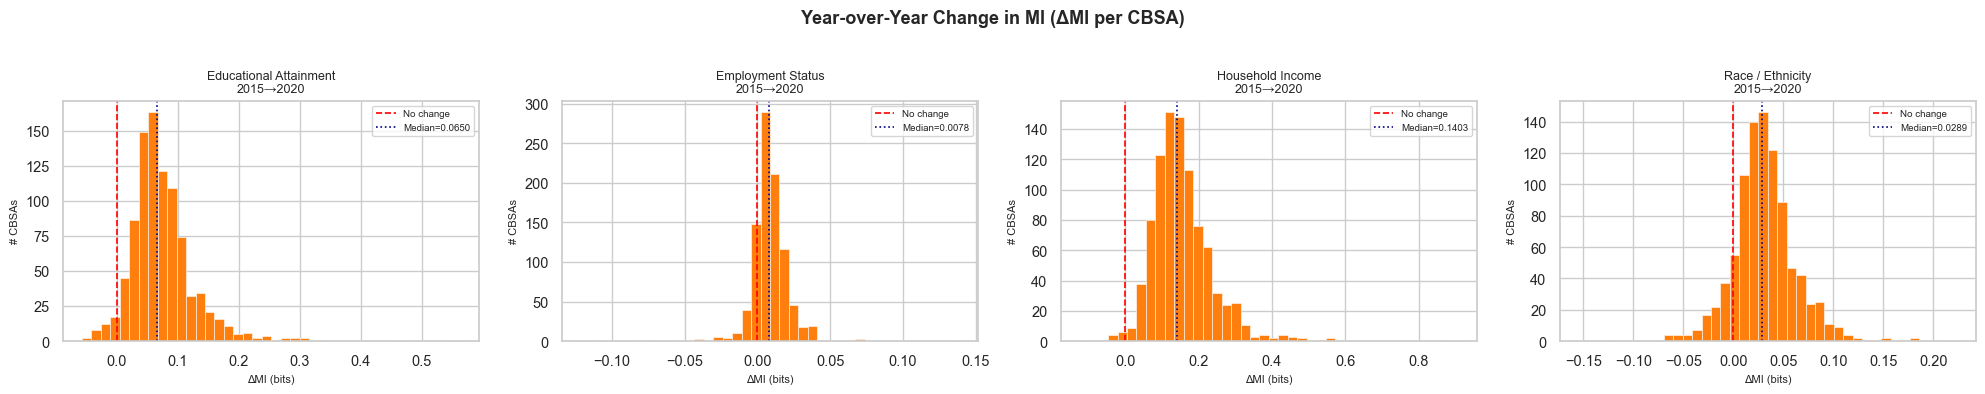

In [6]:
def plot_delta_mi(mi: pd.DataFrame) -> None:
    """Plot distribution of CBSA-level MI change between consecutive years."""
    df = mi.dropna(subset=['avg_dkl_cbsa_pop']).copy()
    df['var_label'] = df['var_group'].map(VAR_GROUP_LABELS).fillna(df['var_group'].str.title())

    pivot = df.pivot_table(
        index=['cbsa_title', 'var_label'],
        columns='year',
        values='avg_dkl_cbsa_pop'
    )

    years = sorted(pivot.columns)
    if len(years) < 2:
        print('Need at least two years to compute delta MI.')
        return

    delta_frames = []
    for i in range(1, len(years)):
        y0, y1 = years[i - 1], years[i]
        if y0 not in pivot.columns or y1 not in pivot.columns:
            continue
        delta = (pivot[y1] - pivot[y0]).dropna().reset_index()
        delta.columns = ['cbsa_title', 'var_label', 'delta_mi']
        delta['period'] = f'{y0}→{y1}'
        delta_frames.append(delta)

    if not delta_frames:
        print('No consecutive year pairs found.')
        return

    delta_df = pd.concat(delta_frames, ignore_index=True)
    var_labels = sorted(delta_df['var_label'].unique())

    fig, axes = plt.subplots(
        len(delta_df['period'].unique()), len(var_labels),
        figsize=(5 * len(var_labels), 4 * len(delta_df['period'].unique())),
        squeeze=False
    )
    fig.suptitle('Year-over-Year Change in MI (ΔMI per CBSA)', fontsize=13, fontweight='bold')

    for row_idx, period in enumerate(sorted(delta_df['period'].unique())):
        for col_idx, vl in enumerate(var_labels):
            ax = axes[row_idx][col_idx]
            sub = delta_df[(delta_df['period'] == period) & (delta_df['var_label'] == vl)]
            if sub.empty:
                ax.set_visible(False)
                continue

            ax.hist(sub['delta_mi'], bins=40, color=PALETTE[1], edgecolor='white', linewidth=0.4)
            ax.axvline(0, color='red', linewidth=1.2, linestyle='--', label='No change')
            ax.axvline(sub['delta_mi'].median(), color='navy', linewidth=1.2,
                       linestyle=':', label=f'Median={sub["delta_mi"].median():.4f}')
            ax.set_title(f'{vl}\n{period}', fontsize=9)
            ax.set_xlabel('ΔMI (bits)', fontsize=8)
            ax.set_ylabel('# CBSAs', fontsize=8)
            ax.legend(fontsize=7)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_delta_mi(mi_df)


## 5. Heatmap — Study Cities × Variable Group × Year

Focus on the four cities in `config.CITIES` and show MI as a colour-encoded
heatmap so year-over-year and cross-dimension comparisons are quick to read.


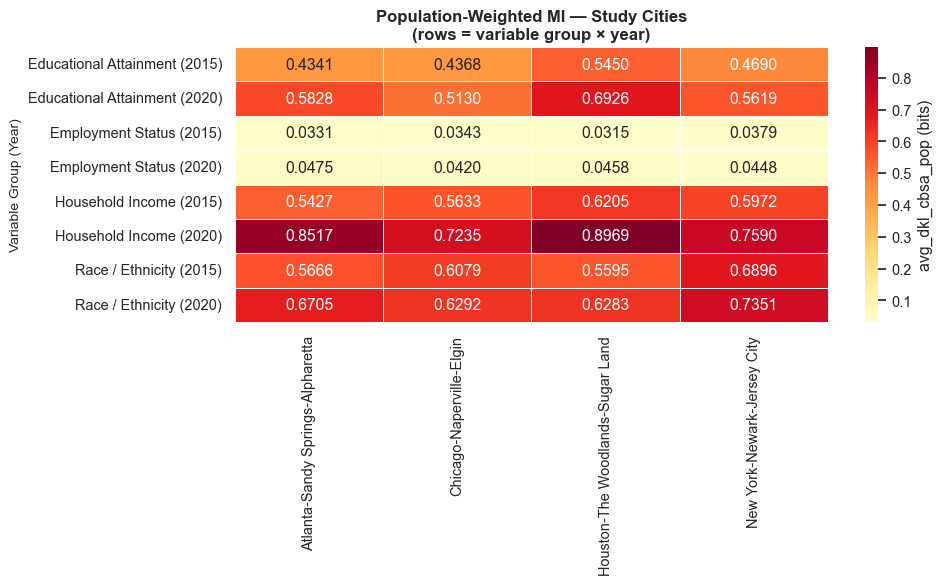

In [7]:
def plot_city_heatmap(mi: pd.DataFrame, cities: list) -> None:
    """Heatmap of avg_dkl_cbsa_pop for study cities, rows = var_group×year."""
    # Filter to study cities (partial match on cbsa_title)
    city_patterns = [c.split(',')[0] for c in cities]
    mask = mi['cbsa_title'].str.contains(
        '|'.join(city_patterns), case=False, na=False
    )
    sub = mi[mask].copy()

    if sub.empty:
        print(f'No data matched for cities: {cities}\n'
              'Check that cbsa_title values align with config.CITIES.')
        return

    sub['var_label'] = sub['var_group'].map(VAR_GROUP_LABELS).fillna(sub['var_group'].str.title())
    sub['row_key']   = sub['var_label'] + ' (' + sub['year'].astype(str) + ')'
    sub['city_short'] = sub['cbsa_title'].str.split(',').str[0]

    pivot = sub.pivot_table(
        index='row_key', columns='city_short',
        values='avg_dkl_cbsa_pop', aggfunc='mean'
    )

    fig, ax = plt.subplots(figsize=(max(8, len(pivot.columns) * 2.5), max(6, len(pivot) * 0.6)))
    sns.heatmap(
        pivot,
        annot=True, fmt='.4f', linewidths=0.4,
        cmap='YlOrRd', cbar_kws={'label': 'avg_dkl_cbsa_pop (bits)'},
        ax=ax
    )
    ax.set_title(
        'Population-Weighted MI — Study Cities\n'
        '(rows = variable group × year)',
        fontsize=12, fontweight='bold'
    )
    ax.set_xlabel('')
    ax.set_ylabel('Variable Group (Year)', fontsize=10)
    plt.tight_layout()
    plt.show()


plot_city_heatmap(mi_df, CITIES)


## 6. Ranked-Change Lollipop — Which CBSAs Changed Most?

Identify the CBSAs that experienced the largest absolute change in MI between
the earliest and latest available year for income segregation.


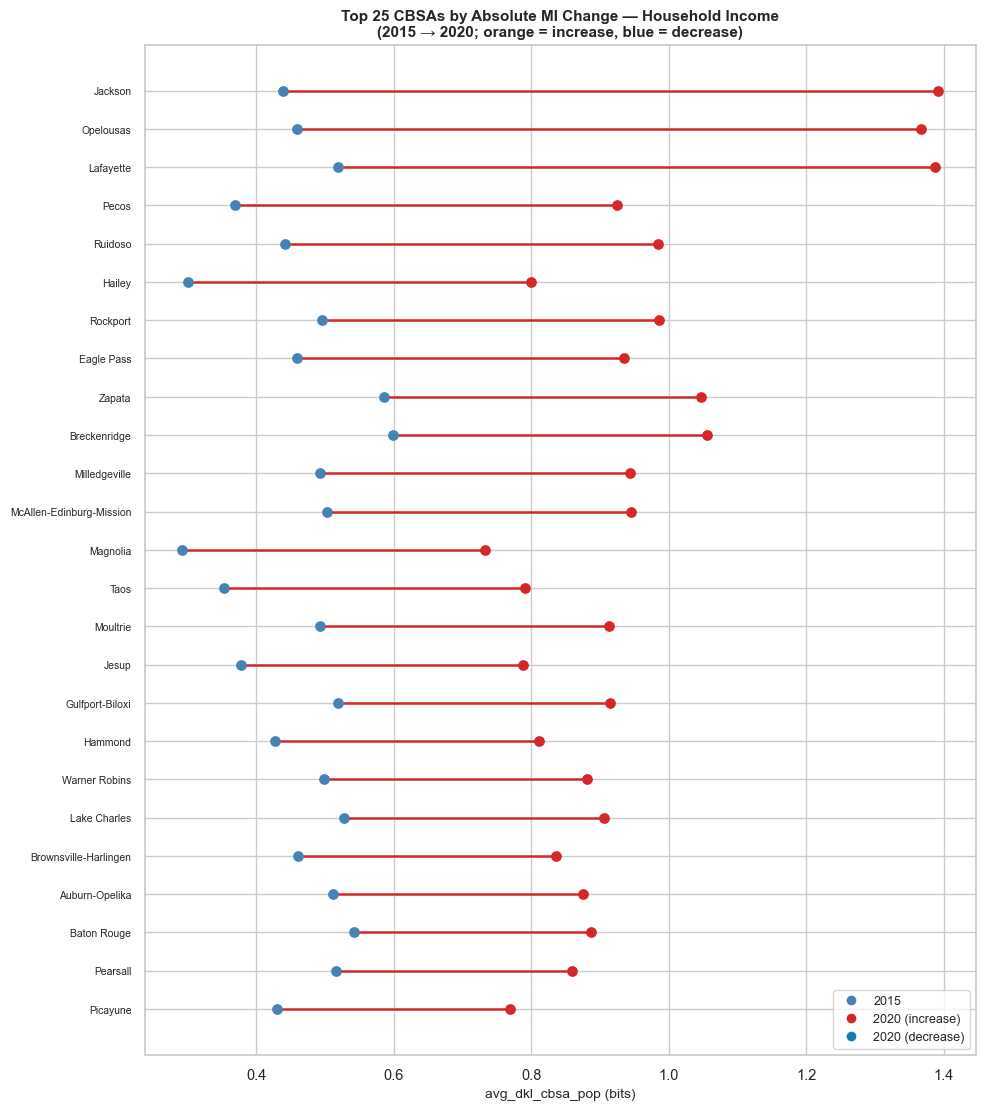

In [8]:
def plot_lollipop_top_changers(mi: pd.DataFrame, var_group: str = 'income',
                                top_n: int = 25) -> None:
    """Lollipop chart of CBSAs with largest absolute MI change."""
    sub = (
        mi[mi['var_group'] == var_group]
        .dropna(subset=['avg_dkl_cbsa_pop'])
        .drop_duplicates(subset=['cbsa_title', 'year'])   # ensure unique per cbsa × year
        .copy()
    )
    if sub.empty:
        print(f'No data for var_group={var_group!r}')
        return

    years = sorted(sub['year'].unique())
    if len(years) < 2:
        print('Need at least 2 years for change analysis.')
        return

    y0, y1 = years[0], years[-1]
    pivot = sub.pivot_table(index='cbsa_title', columns='year', values='avg_dkl_cbsa_pop')

    if y0 not in pivot.columns or y1 not in pivot.columns:
        print(f'Years {y0} and/or {y1} not found in pivoted data.')
        return

    delta = (pivot[y1] - pivot[y0]).dropna().abs().nlargest(top_n)
    cbsas = delta.index.tolist()

    from_vals = pivot.loc[cbsas, y0].dropna()
    to_vals   = pivot.loc[cbsas, y1].dropna()
    common = sorted(
        [c for c in cbsas if c in from_vals.index and c in to_vals.index],
        key=lambda c: abs(to_vals.loc[c] - from_vals.loc[c]),
        reverse=True,
    )

    short_labels = {c: c.split(',')[0] for c in common}

    fig, ax = plt.subplots(figsize=(10, max(6, len(common) * 0.45)))
    vg_label = VAR_GROUP_LABELS.get(var_group, var_group.title())

    for i, city in enumerate(reversed(common)):
        v0 = from_vals.loc[city]
        v1 = to_vals.loc[city]
        color = PALETTE[3] if v1 > v0 else PALETTE[0]
        ax.plot([v0, v1], [i, i], color=color, linewidth=1.8, zorder=1)
        ax.scatter([v0], [i], color='steelblue', zorder=2, s=45, label=str(y0) if i == 0 else '')
        ax.scatter([v1], [i], color=color,       zorder=2, s=45, label=str(y1) if i == 0 else '')

    ax.set_yticks(range(len(common)))
    ax.set_yticklabels([short_labels[c] for c in reversed(common)], fontsize=7.5)
    ax.set_xlabel('avg_dkl_cbsa_pop (bits)', fontsize=10)
    ax.set_title(
        f'Top {top_n} CBSAs by Absolute MI Change — {vg_label}\n'
        f'({y0} → {y1}; orange = increase, blue = decrease)',
        fontsize=11, fontweight='bold'
    )
    from matplotlib.lines import Line2D
    ax.legend(
        handles=[
            Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue',
                   markersize=8, label=str(y0)),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=PALETTE[3],
                   markersize=8, label=f'{y1} (increase)'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=PALETTE[0],
                   markersize=8, label=f'{y1} (decrease)'),
        ],
        fontsize=9, loc='lower right'
    )
    plt.tight_layout()
    plt.show()


plot_lollipop_top_changers(mi_df, var_group='income')


In [9]:
# Summary table — median MI per var_group × year
summary = (
    mi_df.dropna(subset=['avg_dkl_cbsa_pop'])
    .groupby(['var_group', 'year'])['avg_dkl_cbsa_pop']
    .agg(['median', 'mean', 'std', 'count'])
    .round(5)
    .rename(columns={'median': 'median_MI', 'mean': 'mean_MI',
                      'std': 'std_MI', 'count': 'n_CBSAs'})
)
summary


median_MI  mean_MI   std_MI  n_CBSAs
var_group year                                      
educ      2015    0.32156  0.32677  0.08196      998
          2020    0.39184  0.40050  0.10609      998
empl      2015    0.03078  0.04059  0.03363      998
          2020    0.03965  0.04926  0.03433      998
income    2015    0.45718  0.45237  0.09124      998
          2020    0.60644  0.60718  0.13791      998
race      2015    0.21430  0.23994  0.13108      998
          2020    0.24930  0.27105  0.13646      998